<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/LondonBikeSharing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)


In [4]:
df = pd.read_csv('/content/london_merged.csv')

In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")

In [6]:
df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


In [7]:
import math
from sklearn.preprocessing import RobustScaler

training_data_len = math.ceil(len(df) *.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)

(17414, 13) (15673, 13) (1765, 13)


In [8]:
# Scale the all of the data from columns ['t1', 't2', 'hum', 'wind_speed']
train_trans = train[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1', 't2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
train.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

#Scale the all of the data from columns ['cnt']
train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [9]:
from tqdm import tqdm_notebook as tqdm

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/15649 [00:00<?, ?it/s]

In [10]:
#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1741 [00:00<?, ?it/s]

In [11]:
# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

Train size:
(15649, 24, 12) (15649,)
Test size:
(1741, 24, 12) (1741,)


In [12]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 

model = Sequential()
model.add(Bidirectional(LSTM(50,input_shape=(x_train.shape[1],x_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam",loss="mse")

# prepared_model = model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=[X_test,y_test])

history = model.fit(x_train, y_train, epochs=150, batch_size=24, validation_split=0.1, shuffle=True)

Epoch 1/150
587/587 [==============================] - 19s 21ms/step - loss: 0.3296 - val_loss: 0.2685
Epoch 2/150
587/587 [==============================] - 11s 19ms/step - loss: 0.1423 - val_loss: 0.1372
Epoch 3/150
587/587 [==============================] - 13s 23ms/step - loss: 0.0862 - val_loss: 0.0857
Epoch 4/150
587/587 [==============================] - 15s 25ms/step - loss: 0.0659 - val_loss: 0.0783
Epoch 5/150
587/587 [==============================] - 18s 31ms/step - loss: 0.0597 - val_loss: 0.0560
Epoch 6/150
587/587 [==============================] - 25s 43ms/step - loss: 0.0535 - val_loss: 0.0765
Epoch 7/150
587/587 [==============================] - 16s 28ms/step - loss: 0.0501 - val_loss: 0.0886
Epoch 8/150
587/587 [==============================] - 11s 19ms/step - loss: 0.0490 - val_loss: 0.0558
Epoch 9/150
587/587 [==============================] - 11s 19ms/step - loss: 0.0444 - val_loss: 0.0657
Epoch 10/150
587/587 [==============================] - 11s 19ms/step - l

In [13]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)#Undo scaling
y_pred

array([[ 729.78656],
       [1359.4271 ],
       [1915.235  ],
       ...,
       [ 454.1574 ],
       [ 338.99268],
       [ 211.79236]], dtype=float32)

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_lstm

409.87108205319333

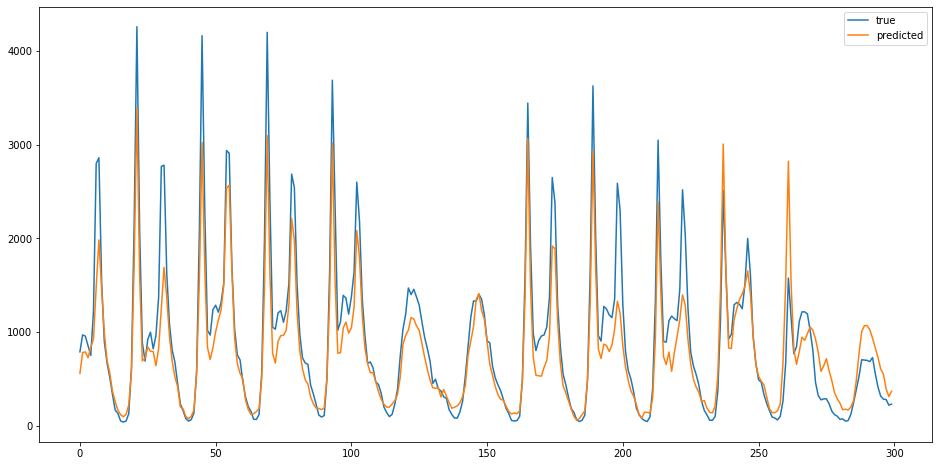

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1500], label='true')
plt.plot(y_pred[1200:1500], label='predicted')
plt.legend()

Text(0, 0.5, 'mse score')

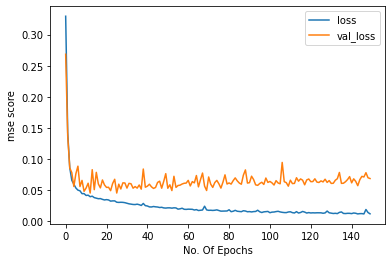

In [16]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")